# RoadRunner ODE integration with django database

For large-scale and large model simulations the simulation data and definition have to be stored in a persistant way. For this all definitions and simulations are managed via a Django database backend.  
Tasks, simulations, parameters and timecourses are easily managable via the common database backend.
`django.setup`
http://localhost:8000/simapp/

### Python and module versions

Since there are several different versions of Python and each Python package has its own release cycle and version number (for example scipy, numpy, matplotlib, etc., which we installed above and will discuss in detail in the following lectures), it is important for the reproducibility of an IPython notebook to record the versions of all these different software packages. If this is done properly it will be easy to reproduce the environment that was used to run a notebook, but if not it can be hard to know what was used to produce the results in a notebook.

To encourage the practice of recording Python and module versions in notebooks, I've created a simple IPython extension that produces a table with versions numbers of selected software components. I believe that it is a good practice to include this kind of table in every notebook you create.

To install this IPython extension, run:

In [1]:
# you only need to do this once
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


In [2]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy, pandas, django, roadrunner, libsbml

Software,Version
Python,2.7.6 64bit [GCC 4.8.2]
IPython,3.1.0
OS,Linux 3.13.0 43 generic x86_64 with Ubuntu 14.04 trusty
numpy,1.8.2
scipy,0.13.3
matplotlib,1.3.1
sympy,0.7.4.1
pandas,0.16.1
django,1.8.1
roadrunner,roadrunner


## Database setup

In [3]:
# import and setup database
import django
django.setup()

In [4]:
# import the database API functions and tools
import simapp.db.api as db_api
import odesim.db.tools as db_tools

In [5]:
# display the backend used
from django.conf import settings
print settings.SETTINGS_MODULE

multiscalesite.settings


In [6]:
# create model in database
comp_model = db_api.create_model(file_path='Koenig_demo.xml')

In [7]:
# Print some information about the model
print 'pk:', comp_model.pk
print 'filepath:', comp_model.filepath

pk: 1
filepath: /home/mkoenig/multiscale-galactose-results/django/model/Koenig_demo.xml


## Database model information

For the model additional information is available in the database  
http://localhost:8000/simapp/

# Simulation

In [8]:
import roadrunner
print(roadrunner.getVersionStr())

1.3; Compiler: gcc 4.6.3, C++ version: 1; JIT Compiler: LLVM-3.4; Date: Jan 12 2015, 16:43:38


** TODO: update RoadRunner to latest version **  
Single Simulation based on the SBML in the database.  
This is only using the file information from the SBMLModel but does not create actual Tasks, Simulations or Timecourses in the database. See below how to create these.

['time', '[A_in]', '[B_in]', '[C_in]', '[A_out]', '[B_out]', '[C_out]']


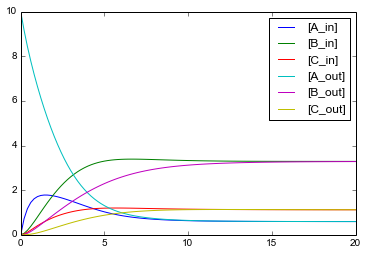

In [9]:
%matplotlib inline
# Uset the filepath from the database
rr = roadrunner.RoadRunner(comp_model.filepath)
print rr.selections
s = rr.simulate(0,20, 100, plot=True)  # equidistant timecourse for 20 [s]

## Single simulation with database

Create parameters and initial concentrations for simulation and setup a task for the simulation.  
In a first step single simulations are run based on given changes to the model.

### Parameters for simulation

Define the parameters and pack all parameters for the simulation in the sample

In [10]:
import simapp.db.api as db_api
reload(db_api)

<module 'simapp.db.api' from '/home/mkoenig/multiscale-galactose/python/multiscalesite/simapp/db/api.pyc'>

In [11]:
db_api.ParameterType.labels

{0: 'GLOBAL_PARAMETER',
 1: 'BOUNDARY_INIT',
 2: 'FLOATING_INIT',
 3: 'NONE_SBML_PARAMETER'}

In [12]:
# TODO: better naming and make this more intuitive
from odesim.dist.samples import Sample, SampleParameter
s = Sample()
# Change the Vmax of b1 (Vmax_b1)
sp1 = SampleParameter('Vmax_b1', 4.0, unit='mole_per_s', parameter_type=db_api.ParameterType.GLOBAL_PARAMETER)
s.add_parameter(sp1)
# Change the initial concentration of A_out
sp2 = SampleParameter('A_out', 8.0, unit='mM', parameter_type=db_api.ParameterType.BOUNDARY_INIT)

s.add_parameter(sp2)
print type(s), s

<class 'odesim.dist.samples.Sample'> {'A_out': <A_out = 8.000E+00 [mM] (BOUNDARY_INIT)>, 'Vmax_b1': <Vmax_b1 = 4.000E+00 [mole_per_s] (GLOBAL_PARAMETER)>}


### Simulation method

Define with which method and settings the model should be simulated. In this case we want and ODE integration with given start and end time and number of steps.

In [13]:
db_api.SettingKey.labels

{0: 'INTEGRATOR',
 1: 'VAR_STEPS',
 2: 'ABS_TOL',
 3: 'REL_TOL',
 4: 'T_START',
 5: 'T_END',
 6: 'STEPS',
 7: 'STIFF',
 8: 'MIN_TIME_STEP',
 9: 'MAX_TIME_STEP',
 10: 'MAX_NUM_STEP'}

In [14]:
settings_dict = {db_api.SettingKey.VAR_STEPS: False,\
                 db_api.SettingKey.T_START: 0.0,\
                 db_api.SettingKey.T_END: 20.0, \
                 db_api.SettingKey.STEPS: 100}

settings = db_api.create_settings(settings_dict)
print(settings)

[<Setting: INTEGRATOR = 1>, <Setting: VAR_STEPS = False>, <Setting: ABS_TOL = 1e-06>, <Setting: REL_TOL = 1e-06>, <Setting: T_START = 0.0>, <Setting: T_END = 20.0>, <Setting: STEPS = 100>, <Setting: STIFF = True>]


In [15]:
db_api.MethodType.labels

{0: 'ODE', 1: 'FBA'}

In [16]:
method = db_api.create_method(method_type=db_api.MethodType.ODE, settings=settings)
method.pk

1

### Task

Define a task for the set of simulations.

In [17]:
task = db_api.create_task(comp_model, integratio, info="Single example simulation.")
task.pk

NameError: name 'integration' is not defined

### Simulations

In [16]:
d = { 'A' : 10}
d.get('B', 'other')

'other'

In [12]:
print(s)
samples = [s]
print(samples)
sims = db_tools.createSimulationsForSamples(task, samples)

{'Vmax_b1': <Vmax_b1 = 4.000E+00 [mole_per_s] (GLOBAL_PARAMETER)>}
[{'Vmax_b1': <Vmax_b1 = 4.000E+00 [mole_per_s] (GLOBAL_PARAMETER)>}]


DataError: value too long for type character varying(20)


## Distribution of parameters
Define distributions of parameters and sample from them.

['time', '[A_in]', '[B_in]', '[C_in]', '[A_out]', '[B_out]', '[C_out]']


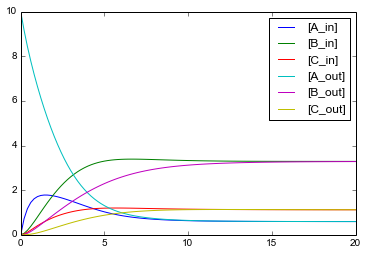

In [15]:
# TODO
%matplotlib inline
rr = roadrunner.RoadRunner('Koenig_demo.xml')
print rr.selections
s = rr.simulate(0,20, 100, plot=True)  # equidistant timecourse for 20 [s]

## HDF5 file storage
For large scale simulations the data has to be stored efficiently in files (HDF5).
Binary file format.